Install efficientnet for pytorch

In [1]:
!pip install efficientnet-pytorch

Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Extract data

In [ ]:
#copy data zip from drive
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/uni/Honours/ISIC_2019.zip ./ISIC_2019.zip

#unzip dataset
!unzip -x -q ISIC_2019.zip

#remove zip file
!rm ISIC_2019.zip

Mounted at /content/drive


Sort data into folders based on class

In [2]:
# function to sort the images into class folders based on given csv file
def copy_images_to_folders(csv_path, image_folder, output_folder):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        image_name = row['image'] + '.jpg'  # Assuming images have '.jpg' extension
        image_path = os.path.join(image_folder, image_name)

        # Iterate through class columns and copy images to the corresponding folders
        for class_name in df.columns[1:]:
            class_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)  # Create folder if it doesn't exist

            if row[class_name] == 1:  # Check if the image belongs to the class
                shutil.copy(image_path, class_folder)

csv_path = 'ISIC_2019_Training_GroundTruth.csv'
image_folder = 'ISIC_2019_Resized'
output_folder = 'ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)

print("done")

done


Select random subset of data from every class for training and validation

In [3]:
# declare variables for model creation
input_folder = 'ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data_subset'  # The desired output folder for "training" and "validation" folders
#data_dir = '/content/data_subset'
sample_limit=None
train_ratio=0.64
val_ratio=0.16
test_ratio=0.2

print(train_ratio+val_ratio+test_ratio)

set_batch_size=32

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

'''
Melanoma (MEL)
Melanocytic nevus (NV)
Basal cell carcinoma (BCC)
Actinic keratosis (AK)
Benign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
Dermatofibroma (DF)
Vascular lesion (VASC)
Squamous cell carcinoma (SCC)
None of the others (UNK)
'''

print("done")

1.0
done


In [4]:
# Remove existing "training" and "validation" folders if they exist
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)
shutil.rmtree(test_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

print("done")

done


In [5]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]
        
        # Limit the number of samples if sample_limit is provided
        if sample_limit is not None:
            images = images[:sample_limit]

        # Randomly shuffle the list of images
        np.random.seed(42)
        np.random.shuffle(images)

        # Calculate the number of samples for training and validation
        class_size = len(images)
        num_training_samples = int(class_size * train_ratio)
        num_val_samples = int(class_size * val_ratio)
        num_test_samples = int(class_size * test_ratio)

        # Create the class subfolders within the output folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        class_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)
        os.makedirs(class_folder_test, exist_ok=True)

        # Copy images to the training folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)
        # Copy images to the validation folder
        for image_name in images[num_training_samples:num_training_samples + num_val_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)
        # Copy images to the test folder
        for image_name in images[num_training_samples + num_val_samples:]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_test)

print("done")

done


In [6]:
#remove unknown folder as no samples
shutil.rmtree("data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data_subset/val/UNK", ignore_errors=True)
shutil.rmtree("data_subset/test/UNK", ignore_errors=True)

In [7]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [8]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#print checks to see if the values are the same - if yes then can remove the assignment here
class_names = image_datasets['train'].classes
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [9]:
# oversample training set

# get the sample size for each class
class_sizes = [len(os.listdir(os.path.join(training_folder, class_name))) for class_name in class_names]

# get the max sample size across classes
max_class_size = max(class_sizes)

# Calculate the desired repetitions for each class
# this is the number of times a sample needs to be repeated to match the max class size
desired_repetitions = [max_class_size // class_size if class_size > 0 else 1 for class_size in class_sizes]

# Iterate through each class and oversample accordingly
for class_index, class_name in enumerate(class_names):
    #get the training folder for the current class
    class_folder_training = os.path.join(training_folder, class_name)
    class_indices = [i for i, label in enumerate(image_datasets['train'].targets) if label == class_index]

    weights = [1.0 if label != class_index else desired_repetitions[class_index] for label in image_datasets['train'].targets]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    # Update the data loader for the "training" set with the weighted sampler
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=set_batch_size, sampler=sampler, num_workers=2)

show sample images

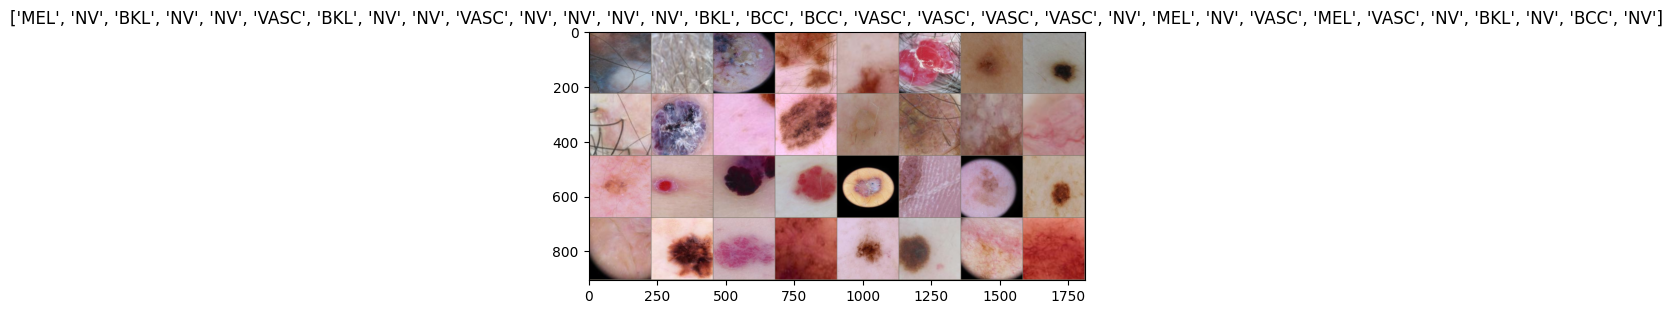

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

model training function

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f'Epoch {epoch + 1}/{num_epochs} - {current_time}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                data_loader = dataloaders[phase]

                for inputs, labels in data_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
                elif phase == 'val':
                    print(f'Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        torch.save(model.state_dict(), best_model_params_path)
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    return model

temporary fix for efficientnet weights issue

In [12]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [13]:
class CustomEfficientNetB0(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.5):
        super(CustomEfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Identity()  # remove the original fully connected layer
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = dropout_prob

    def forward(self, x):
        x = self.model(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return x

# Initialize the model with dropout
model_ft = CustomEfficientNetB0(num_classes=len(class_names), dropout_prob=0.5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Use Adam optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


train model

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25 - 2024-02-07 13:23:37
----------
Train Loss: 0.8621, Train Acc: 0.6977
Val Loss: 0.9496, Val Acc: 0.6720

Epoch 2/25 - 2024-02-07 13:25:16
----------
Train Loss: 0.7374, Train Acc: 0.7417
Val Loss: 0.9606, Val Acc: 0.6616

Epoch 3/25 - 2024-02-07 13:26:47
----------
Train Loss: 0.7041, Train Acc: 0.7541
Val Loss: 0.9090, Val Acc: 0.6715

Epoch 4/25 - 2024-02-07 13:28:19
----------
Train Loss: 0.6644, Train Acc: 0.7645
Val Loss: 0.8477, Val Acc: 0.7029

Epoch 5/25 - 2024-02-07 13:29:50
----------
Train Loss: 0.6622, Train Acc: 0.7665
Val Loss: 0.8612, Val Acc: 0.6792

Epoch 6/25 - 2024-02-07 13:31:22
----------
Train Loss: 0.6173, Train Acc: 0.7824
Val Loss: 1.0889, Val Acc: 0.6614

Epoch 7/25 - 2024-02-07 13:32:53
----------
Train Loss: 0.6334, Train Acc: 0.7788
Val Loss: 0.8463, Val Acc: 0.6940

Epoch 8/25 - 2024-02-07 13:34:24
----------
Train Loss: 0.5743, Train Acc: 0.7927
Val Loss: 0.6968, Val Acc: 0.7431

Epoch 9/25 - 2024-02-07 13:35:55
----------
Train Loss: 0.5101, 

visualise trained model

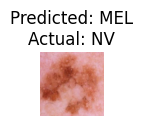

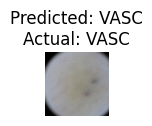

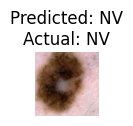

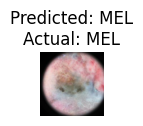

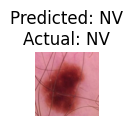

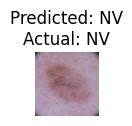

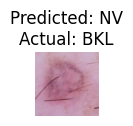

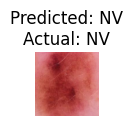

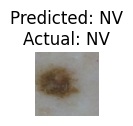

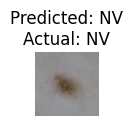

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                title = f'Predicted: {predicted_class}\nActual: {actual_class}'
                ax.set_title(title)

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft, num_images=10)

In [16]:
# Lists to store results
risks_list = []
labels_list = []

In [17]:
def calculate_risks(guesses_are_correct, uncertainties):
    risks = []

    while uncertainties:
        risk = 1 - (sum(guesses_are_correct) / len(guesses_are_correct))
        risks.append(risk)

        max_uncertainty_index = uncertainties.index(max(uncertainties))
        uncertainties.pop(max_uncertainty_index)
        guesses_are_correct.pop(max_uncertainty_index)

    risks.reverse()

    return risks

In [18]:
def calculate_softmax_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on softmax probabilities
            for idx in range(len(predicted)):
                predicted_class = predicted[idx].item()
                uncertainty = 1.0 - probabilities[idx, predicted_class].item()  # Using confidence as uncertainty
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_softmax_uncertainties(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("Softmax Response")

In [19]:
def calculate_random_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Generate a single random uncertainty value for each predicted class
            for idx in range(len(predicted)):
                uncertainty = random.random()
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_random_uncertainties(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("Random Uncertainties")

In [20]:
def calculate_mc_dropout_uncertainties(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            mean_predictions = torch.zeros(num_samples, inputs.size(0), len(class_names)).to(device)

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                model.train()  # Enable dropout
                outputs = model(inputs)
                predictions = F.softmax(outputs, dim=1)
                mean_predictions[i] = predictions
                model.eval()  # Disable dropout for evaluation

            # Calculate mean prediction across samples
            mean_prediction = torch.mean(mean_predictions, dim=0)

            # Calculate uncertainty using mean prediction
            uncertainties.extend(1.0 - torch.max(mean_prediction, dim=1)[0].cpu().numpy())

            # Determine correctness of predictions
            _, predicted = torch.max(mean_prediction, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_mc_dropout_uncertainties(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("Monte Carlo Dropout")

2024-02-07 14:02:31.992081 - Batch 1/159 processed
2024-02-07 14:02:36.083502 - Batch 2/159 processed
2024-02-07 14:02:40.175146 - Batch 3/159 processed
2024-02-07 14:02:44.267165 - Batch 4/159 processed
2024-02-07 14:02:48.359036 - Batch 5/159 processed
2024-02-07 14:02:52.452382 - Batch 6/159 processed
2024-02-07 14:02:56.543772 - Batch 7/159 processed
2024-02-07 14:03:00.637229 - Batch 8/159 processed
2024-02-07 14:03:04.730668 - Batch 9/159 processed
2024-02-07 14:03:08.824960 - Batch 10/159 processed
2024-02-07 14:03:12.916217 - Batch 11/159 processed
2024-02-07 14:03:17.007741 - Batch 12/159 processed
2024-02-07 14:03:21.099780 - Batch 13/159 processed
2024-02-07 14:03:25.189634 - Batch 14/159 processed
2024-02-07 14:03:29.280912 - Batch 15/159 processed
2024-02-07 14:03:33.371492 - Batch 16/159 processed
2024-02-07 14:03:37.466430 - Batch 17/159 processed
2024-02-07 14:03:41.556312 - Batch 18/159 processed
2024-02-07 14:03:45.647345 - Batch 19/159 processed
2024-02-07 14:03:49.7

In [21]:
risks_list.append(calculate_risks(*calculate_mc_dropout_uncertainties(model_ft, dataloaders['test'], class_names, device, num_samples=1)))
labels_list.append("1 Sample MCD")

2024-02-07 14:13:21.873638 - Batch 1/159 processed
2024-02-07 14:13:21.925636 - Batch 2/159 processed
2024-02-07 14:13:21.975636 - Batch 3/159 processed
2024-02-07 14:13:22.025637 - Batch 4/159 processed
2024-02-07 14:13:22.075638 - Batch 5/159 processed
2024-02-07 14:13:22.125639 - Batch 6/159 processed
2024-02-07 14:13:22.173637 - Batch 7/159 processed
2024-02-07 14:13:22.222637 - Batch 8/159 processed
2024-02-07 14:13:22.271637 - Batch 9/159 processed
2024-02-07 14:13:22.320637 - Batch 10/159 processed
2024-02-07 14:13:22.369636 - Batch 11/159 processed
2024-02-07 14:13:22.417637 - Batch 12/159 processed
2024-02-07 14:13:22.466636 - Batch 13/159 processed
2024-02-07 14:13:22.515636 - Batch 14/159 processed
2024-02-07 14:13:22.563638 - Batch 15/159 processed
2024-02-07 14:13:22.612637 - Batch 16/159 processed
2024-02-07 14:13:22.661637 - Batch 17/159 processed
2024-02-07 14:13:22.710637 - Batch 18/159 processed
2024-02-07 14:13:22.759636 - Batch 19/159 processed
2024-02-07 14:13:22.8

In [22]:
# Interpolate the data for smoother curves
x_values = np.arange(len(risks_list[0]))
total_steps = len(x_values)

# Convert x-values to percentage
x_smooth_percentage = (x_values / total_steps) * 100

# Create a smooth range for the x-axis
x_smooth_percentage_interp = np.linspace(x_smooth_percentage.min(), x_smooth_percentage.max(), 300)

Softmax Response AURC: 7.030215420241002
Random Uncertainties AURC: 17.83242449154485
Monte Carlo Dropout AURC: 17.03941206129364
1 Sample MCD AURC: 19.174998201749275


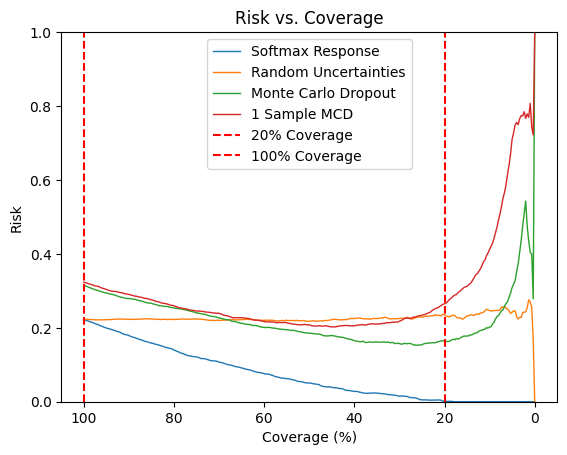

In [23]:
def plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage):
    for risks, label in zip(risks_list, labels_list):
        risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, risks)
        plt.plot(x_smooth_percentage_interp, risks_smooth, label=label, linewidth=1)

        # Find indices corresponding to values less than or equal to 20% coverage
        cutoff_index = np.argmax(x_smooth_percentage_interp >= 20)

        # Calculate area under the curve from 100% coverage to the 20% cutoff
        area = np.trapz(risks_smooth[cutoff_index:], x=x_smooth_percentage_interp[cutoff_index:])
        print(f"{label} AURC: {area}")

    # x-axis label with a percentage
    plt.xlabel('Coverage (%)')
    plt.ylabel('Risk')
    plt.title('Risk vs. Coverage')

    # Add a vertical line at approximately 20% coverage
    plt.axvline(x=20, color='red', linestyle='--', label='20% Coverage')

    # Add a vertical line at approximately 100% coverage
    plt.axvline(x=100, color='red', linestyle='--', label='100% Coverage')

    # Adjust the y-axis limits
    plt.ylim(0, 1)

    # Invert the x-axis
    plt.gca().invert_xaxis()

    # Show legend
    plt.legend()

    plt.show()

plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)